In [525]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [526]:
# Configurações de visualização
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- Carregar o Dataset ---
# Usamos index_col='date' e parse_dates=True para que o Pandas
# entenda nosso dataset como uma série temporal.

FILE_NAME = '../data/dataset-final-final.csv'

try:
    df = pd.read_csv(FILE_NAME, index_col='date', parse_dates=True)
except FileNotFoundError:
    print(f"Erro: Arquivo '{FILE_NAME}' não encontrado.")
    # Se der erro, pare aqui e verifique o nome do arquivo.
    raise

print(f"Dataset '{FILE_NAME}' carregado com sucesso.")
print(f"Dimensão: {df.shape}")
print("\nPrimeiras 5 linhas:")

# Verificar se as colunas necessárias do Compound estão presentes
required_cols = ['total_deposit_usd', 'deposit_apy', 'utilization_rate']
if not all(col in df.columns for col in required_cols):
    print("\nERRO: Colunas do Compound não encontradas. Verifique seu merge.")
else:
    print("\nColunas do Compound validadas com sucesso.")

Dataset '../data/dataset-final-final.csv' carregado com sucesso.
Dimensão: (1002, 32)

Primeiras 5 linhas:

Colunas do Compound validadas com sucesso.


In [527]:
df.head()

,Y_Aave_APY,X_Aave_Utilization,totalValueLockedUSD,Y_SOFR,X_USDC_Depeg_Risk,X_BTC_Price,X_ETH_Price,X_VIX,X_DGS2,X_Gas_Price_Gwei,...,total_tvl_aave,total_tvl_compound,total_tvl_defi,apy_aave,apy_compound,DeFi_APY_Ponderado,Y_Target_Spread_Ponderado,Spread_Aave_Compound,compound_utilization_rate,delta_total_defi_tvl_7d
date,,,,,,,,,,,,,,,,,,,,,
2023-02-10,1.065206,0.516046,2.954084e+07,4.55,0.395367,21629.58,1513.90,20.53,4.50,29.368859,...,2.954084e+07,1.530275e+08,1.825683e+08,1.065206,2.469392,2.242184,-2.307816,-1.404186,75.981277,0.047703
2023-02-11,1.351110,0.581190,2.983011e+07,4.55,0.366080,21857.51,1538.26,20.53,4.50,21.415378,...,2.983011e+07,1.531180e+08,1.829482e+08,1.351110,2.407529,2.235278,-2.314722,-1.056419,74.077824,0.041050
2023-02-12,1.477193,0.607706,2.901072e+07,4.55,0.375003,21784.08,1514.41,20.53,4.50,21.067639,...,2.901072e+07,1.534786e+08,1.824893e+08,1.477193,2.394697,2.248840,-2.301160,-0.917504,73.682817,0.033322
2023-02-13,1.234612,0.555573,3.404628e+07,4.55,0.415355,21786.33,1506.71,20.34,4.52,29.595632,...,3.404628e+07,1.532760e+08,1.873223e+08,1.234612,2.199709,2.024301,-2.525699,-0.965098,67.678167,0.041849
2023-02-14,1.718342,0.655439,3.610464e+07,4.55,0.387936,22193.69,1557.20,18.91,4.60,64.056071,...,3.610464e+07,1.535504e+08,1.896550e+08,1.718342,2.200525,2.108732,-2.441268,-0.482184,67.708469,0.045900


[]

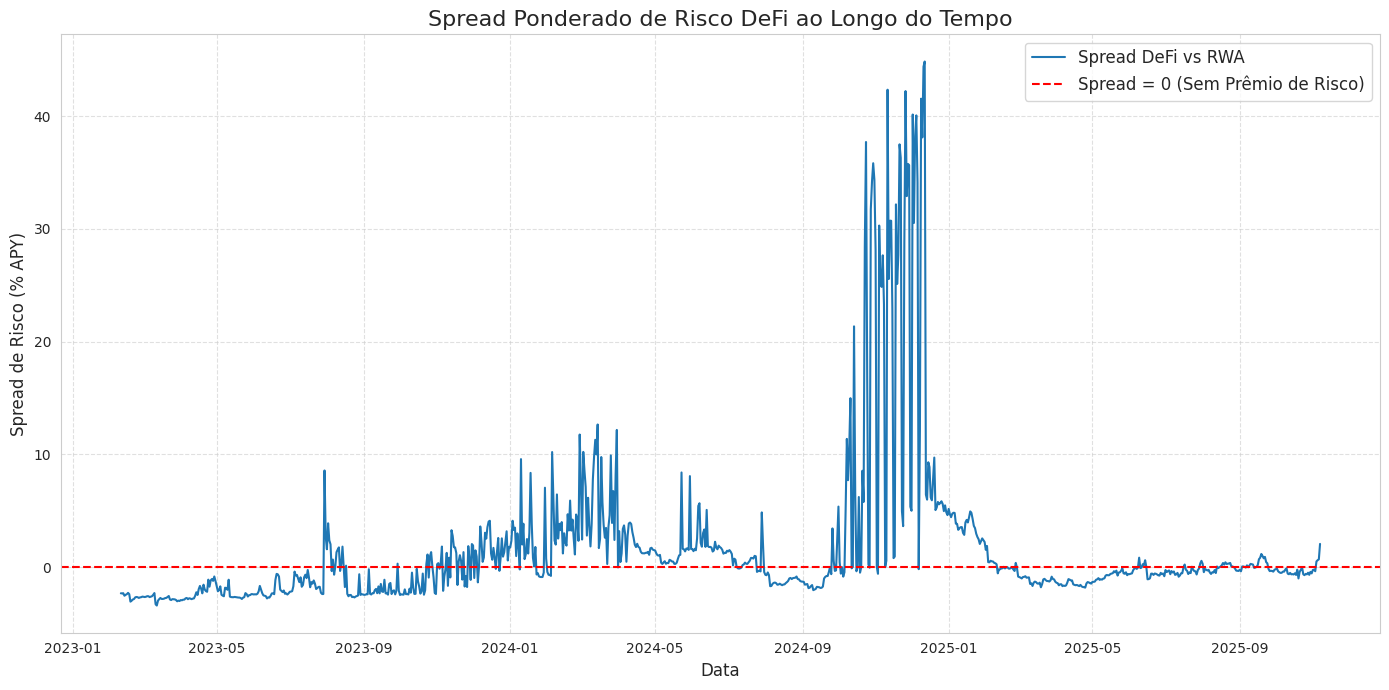

In [528]:
# --- 3. Gerar "O Gráfico da Tese" (Plot de Série Temporal) ---
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x=df.index, y=df['Y_Target_Spread_Ponderado'], label='Spread DeFi vs RWA')

# Adicionar uma linha de base em 0
ax.axhline(0, ls='--', color='red', lw=1.5, label='Spread = 0 (Sem Prêmio de Risco)')

# Melhorar a formatação
plt.title('Spread Ponderado de Risco DeFi ao Longo do Tempo', fontsize=16)
plt.ylabel('Spread de Risco (% APY)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Plotar o gráfico
plt.plot()


In [529]:
# Bloco 2: Engenharia de Features (Alvo Ponderado e Features de Cluster)

print("Iniciando Engenharia de Features...")

# --- 1. Criar o Alvo Ponderado (y) ---
# Usamos os TVLs (totalValueLockedUSD e total_deposit_usd) como pesos.

# Pesos (TVLs)
tvl_aave = df['totalValueLockedUSD']
tvl_compound = df['total_deposit_usd']
total_tvl_defi = tvl_aave + tvl_compound

# APYs
apy_aave = df['Y_Aave_APY']
apy_compound = df['deposit_apy']

# Cálculo do APY Ponderado
df['DeFi_APY_Ponderado'] = ((apy_aave * tvl_aave) + (apy_compound * tvl_compound)) / total_tvl_defi

# Cálculo do Novo Alvo (Spread Ponderado)
df['Y_Target_Spread_Ponderado'] = df['DeFi_APY_Ponderado'] - df['Y_SOFR']
print("Novo alvo 'Y_Target_Spread_Ponderado' criado.")

# --- 2. Criar Novas Features de Clusterização (X) ---
# O 'X_' no início ajuda a identificar features.

# Feature 1: Spread Interno DeFi (Aave vs Compound)
df['X_Spread_Aave_Compound'] = apy_aave - apy_compound

# Feature 2: Variação % do TVL DeFi (Fluxo de Capital em 7 dias)
df['X_Delta_TVL_DeFi_7D_pct'] = total_tvl_defi.pct_change(7)

# Feature 3: Renomear a utilização do Compound para o padrão 'X_'
df['X_Compound_Utilization'] = df['utilization_rate']

# --- 3. Limpeza Pós-Engenharia ---
# A feature 'X_Delta_TVL_DeFi_7D_pct' criou NaNs nas primeiras 7 linhas.
# Vamos removê-los para ter um dataset 100% limpo para modelagem.
df_model = df.dropna()

print("Novas features 'X_' para clusterização criadas.")
print(f"Dimensão final do dataset (pós-NaN drop): {df_model.shape}")


# É uma boa prática salvar este dataset final
df_model.to_csv('dataset_para_modelagem.csv')
print("Dataset final 'dataset_para_modelagem.csv' salvo.")

Iniciando Engenharia de Features...
Novo alvo 'Y_Target_Spread_Ponderado' criado.
Novas features 'X_' para clusterização criadas.
Dimensão final do dataset (pós-NaN drop): (995, 35)
Dataset final 'dataset_para_modelagem.csv' salvo.


In [530]:
# Bloco 3: Definição e Seleção de Features (X) e Alvo (y)

# 1. Defina sua variável alvo (y)
TARGET_COLUMN = 'Y_Target_Spread_Ponderado'
y = df_model[TARGET_COLUMN]


# 2. Selecione as features para o modelo (X)
# Esta é a etapa de "Feature Selection"
# Inclua suas features antigas + as novas que criamos
FEATURE_COLUMNS = [
    # --- Features Antigas (TradFi + Aave) ---
    'X_Aave_Utilization',
    'X_USDC_Depeg_Risk',
    # 'X_BTC_Price',  # Preços absolutos podem ser ruins para clusterização
    # 'X_ETH_Price',
    'X_VIX',
    'X_DGS2',
    'X_Gas_Price_Gwei',
    'X_ETH_Returns',
    'X_ETH_Vol_7D',
    'X_BTC_Returns',
    'X_BTC_Vol_7D',
    'X_Gas_MA_7D',
    'X_VIX_Pct_Change',

    # --- NOVAS FEATURES (Compound + Mercado) ---
    'X_Compound_Utilization',   # Stress/Demanda no Compound
    'X_Spread_Aave_Compound',   # Fricção interna do DeFi
    'X_Delta_TVL_DeFi_7D_pct' # Fluxo de Capital/Momentum
]

# Garantir que estamos usando apenas colunas que realmente existem
features_existentes = [col for col in FEATURE_COLUMNS if col in df_model.columns]
X = df_model[features_existentes]

print(f"Total de features selecionadas para X: {len(features_existentes)}")

# 3. Padronizar (Standardize) as features
# O KMeans é sensível à escala, então este passo é OBRIGATÓRIO.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converter de volta para DataFrame para facilitar a análise
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

Total de features selecionadas para X: 14


In [531]:
# Bloco 4: Divisão Treino/Teste e Clusterização (Fit no Treino)

# 1. Definir o ponto de corte para treino/teste (Split Temporal)
# Usando 80% dos dados para treino, 20% para teste
split_index = int(len(df_model) * 0.8)

# --- Dividir TODOS os dataframes ---

# Dados padronizados (para KMeans)
X_train_scaled = X_scaled.iloc[:split_index]
X_test_scaled = X_scaled.iloc[split_index:]

# Dados brutos (para o Lasso)
X_raw = df_model[features_existentes] # Re-selecionar do df_model
X_train_raw = X_raw.iloc[:split_index]
X_test_raw = X_raw.iloc[split_index:]

# Alvo (y)
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# DataFrames completos (para análise e plots)
df_train = df_model.iloc[:split_index].copy()
df_test = df_model.iloc[split_index:].copy()

print(f"Dados divididos: {len(df_train)} treino, {len(df_test)} teste.")
print(f"Data de corte: {df_test.index[0]}")

# 2. Treinar o modelo KMeans (APENAS NO TREINO)
N_CLUSTERS = 4 # 3 regimes (Calmo, Stress, Pânico)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)

# 3. Fit (treino) e Predict (teste)
print(f"--- Treinando K-Means (k={N_CLUSTERS}) nos dados de TREINO ---")
train_regimes = kmeans.fit_predict(X_train_scaled)
print("--- Aplicando clusters aprendidos aos dados de TESTE ---")
test_regimes = kmeans.predict(X_test_scaled)

# 4. Adicionar os clusters aos DataFrames de treino/teste
df_train = df_train.assign(cluster=train_regimes)
df_test = df_test.assign(cluster=test_regimes)

print("\nClusterização concluída e aplicada a treino/teste.")

Dados divididos: 796 treino, 199 teste.
Data de corte: 2025-04-23 00:00:00
--- Treinando K-Means (k=4) nos dados de TREINO ---
--- Aplicando clusters aprendidos aos dados de TESTE ---

Clusterização concluída e aplicada a treino/teste.


In [532]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# --- 1. Diagnóstico de Estacionariedade (Teste ADF) ---
# Vamos testar a série que foi usada para TREINAR o modelo do Cluster 0.

# Nome da sua variável alvo (definida na Célula 240)
TARGET_COLUMN = 'Y_Target_Spread_Ponderado' 
CLUSTER_ID_PARA_TESTAR = 0

print(f"--- Executando Teste Dickey-Fuller Aumentado (ADF) ---")
print(f"Cluster: {CLUSTER_ID_PARA_TESTAR}")
print(f"Série: {TARGET_COLUMN}")
print("------------------------------------------------------")

# Isolar a série temporal alvo APENAS para o cluster 0 do conjunto de TREINO
# O df_train foi criado na célula [241]
try:
    serie_cluster_0_treino = df_train[df_train['cluster'] == CLUSTER_ID_PARA_TESTAR][TARGET_COLUMN]

    if serie_cluster_0_treino.empty:
        print("ERRO: Não foram encontrados dados de treino para o Cluster 0.")
        print("Verifique se o ID do cluster está correto ou se o cluster tem dados de treino.")
    else:
        print(f"Total de pontos de dados no treino do Cluster {CLUSTER_ID_PARA_TESTAR}: {len(serie_cluster_0_treino)}")
        
        # 2. Executar o teste ADF
        # O dropna() garante que, se houver algum NaN (improvável após sua limpeza), ele seja removido.
        adf_result = adfuller(serie_cluster_0_treino.dropna())

        # 3. Formatar e exibir os resultados
        print(f'\nEstatística ADF (ADF Statistic): {adf_result[0]:.4f}')
        print(f'p-valor (p-value): {adf_result[1]:.4f}')
        print('\nValores Críticos:')
        for key, value in adf_result[4].items():
            print(f'\t{key}: {value:.4f} (Se a Estatística ADF for > que este valor, a série é não-estacionária)')

        print("\n--- Interpretação ---")
        if adf_result[1] > 0.05:
            print(f"RESULTADO: Hipótese Nula (H0) NÃO REJEITADA (p-valor = {adf_result[1]:.4f})")
            print(">> A SÉRIE É NÃO-ESTACIONÁRIA (possui raiz unitária).")
            print(">> ISSO EXPLICA O R² NEGATIVO DE -1.8568.")
            print("\n>> PRÓXIMA AÇÃO: Você deve diferenciar a série. Crie um novo alvo (ex: Y_target_diff = ... .diff(1))")
            print(">> e treine o modelo para prever a MUDANÇA no spread, não o NÍVEL.")
        else:
            print(f"RESULTADO: Hipótese Nula (H0) REJEITADA (p-valor = {adf_result[1]:.4f})")
            print(">> A SÉRIE É ESTACIONÁRIA.")
            print(">> O problema do R² negativo é outro (talvez as features defasadas não sejam suficientes).")
            print(">> Considere as outras opções (ARIMAX, GARCH).")

except NameError:
    print("ERRO: O DataFrame 'df_train' não foi encontrado.")
    print("Certifique-se de executar esta célula APÓS a Célula [241] (Divisão Treino/Teste e Clusterização).")
except KeyError:
    print(f"ERRO: A coluna '{TARGET_COLUMN}' ou 'cluster' não foi encontrada em 'df_train'.")

--- Executando Teste Dickey-Fuller Aumentado (ADF) ---
Cluster: 0
Série: Y_Target_Spread_Ponderado
------------------------------------------------------
Total de pontos de dados no treino do Cluster 0: 39

Estatística ADF (ADF Statistic): -2.4153
p-valor (p-value): 0.1375

Valores Críticos:
	1%: -3.6267 (Se a Estatística ADF for > que este valor, a série é não-estacionária)
	5%: -2.9460 (Se a Estatística ADF for > que este valor, a série é não-estacionária)
	10%: -2.6117 (Se a Estatística ADF for > que este valor, a série é não-estacionária)

--- Interpretação ---
RESULTADO: Hipótese Nula (H0) NÃO REJEITADA (p-valor = 0.1375)
>> A SÉRIE É NÃO-ESTACIONÁRIA (possui raiz unitária).
>> ISSO EXPLICA O R² NEGATIVO DE -1.8568.

>> PRÓXIMA AÇÃO: Você deve diferenciar a série. Crie um novo alvo (ex: Y_target_diff = ... .diff(1))
>> e treine o modelo para prever a MUDANÇA no spread, não o NÍVEL.



--- Análise dos Centroides (Média das features Z-score por cluster) ---
cluster                         0         1         2         3
X_Aave_Utilization       1.507265  0.437527  0.269541 -1.613423
X_USDC_Depeg_Risk        0.227544  0.365743 -0.558391 -0.175025
X_VIX                   -0.160890 -0.525699 -0.313118  1.374104
X_DGS2                  -0.189125  0.508090  0.531015 -0.506817
X_Gas_Price_Gwei         0.085402  1.287842 -0.221293 -0.202295
X_ETH_Returns            0.297879  0.108391 -0.088889 -0.113918
X_ETH_Vol_7D             0.474625 -0.154836 -0.346519  0.624268
X_BTC_Returns            0.311678  0.105912 -0.057672 -0.024145
X_BTC_Vol_7D             0.432425  0.211644 -0.196448  0.811242
X_Gas_MA_7D             -0.045141  1.329498 -0.192999 -0.214750
X_VIX_Pct_Change        -0.150971 -0.050252  0.032321  0.084674
X_Compound_Utilization   0.586762  0.459830  0.194640 -1.724193
X_Spread_Aave_Compound   4.575180 -0.227885 -0.126251 -0.235333
X_Delta_TVL_DeFi_7D_pct  0.1854

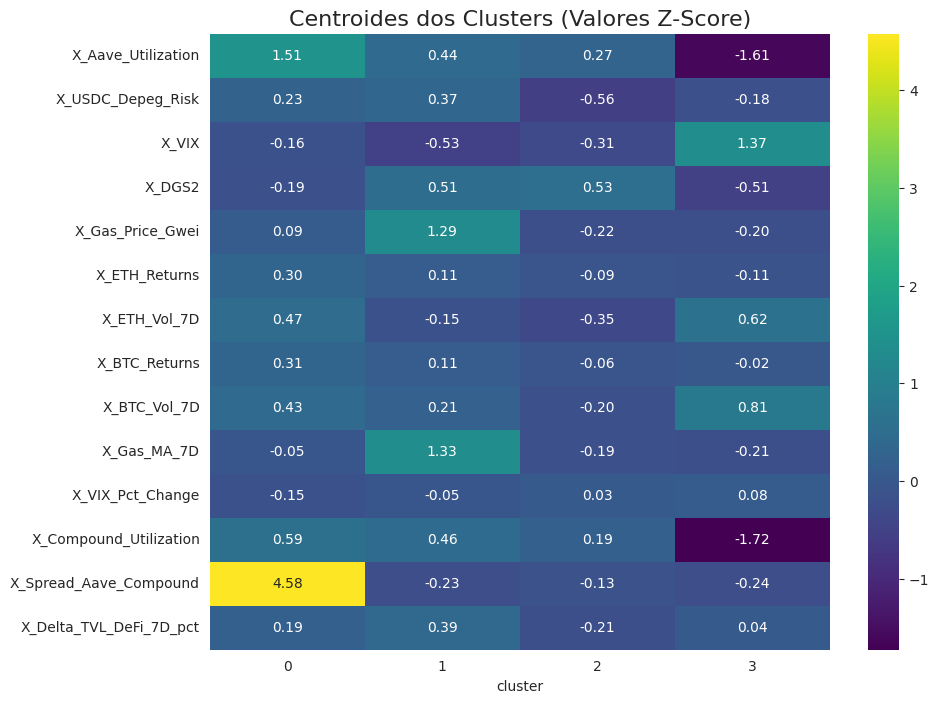

In [533]:
# Bloco 5: Análise dos Centroides (O que cada cluster significa?)

# Criar um dataframe de análise com os dados de treino padronizados
X_train_analysis = X_train_scaled.copy()
X_train_analysis['cluster'] = train_regimes

# Agrupar por cluster e calcular a média (centroides)
# Usamos os dados padronizados (X_train_scaled) para a análise,
# pois as médias dos dados brutos teriam escalas diferentes.
cluster_centers = X_train_analysis.groupby('cluster').mean().T

print("\n--- Análise dos Centroides (Média das features Z-score por cluster) ---")
print(cluster_centers)

# Plotar um heatmap para visualizar facilmente
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_centers, annot=True, cmap='viridis', fmt='.2f')
plt.title('Centroides dos Clusters (Valores Z-Score)', fontsize=16)
plt.plot()
print("\nHeatmap dos centroides salvo como 'cluster_centroids_heatmap.png'")

Plotando áreas dos regimes (axvspan)...
Gráfico de regimes salvo como 'spread_com_regimes_kmeans.png'


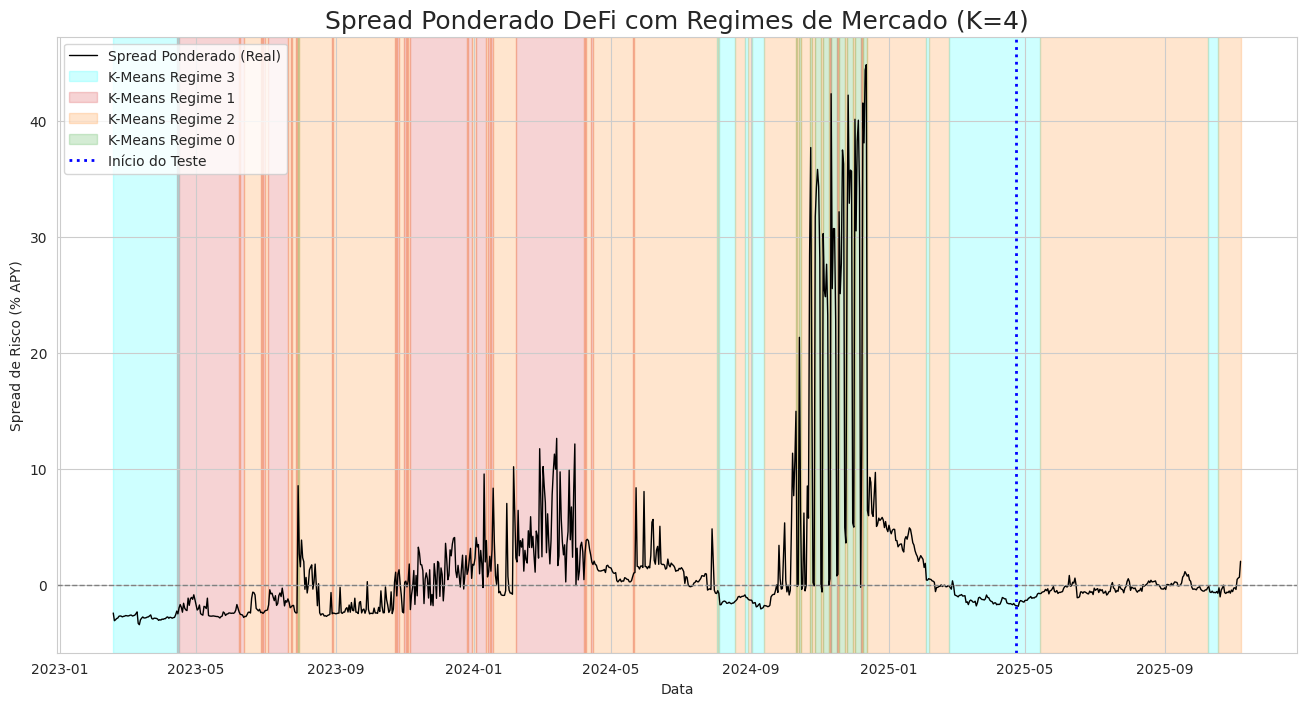

In [534]:
# Bloco 6: Visualização dos Regimes de Mercado (axvspan plot)

# 1. Juntar treino e teste para plotagem contínua
df_plot = pd.concat([df_train, df_test])

# 2. Configurações de Plotagem
plt.figure(figsize=(16, 8))
# Usamos nosso NOVO alvo ponderado
target_plot_column = 'Y_Target_Spread_Ponderado'
# Cores para 3 clusters
colors = ['#2ca02c', '#d62728', '#ff7f0e', "#0effff"] # Verde, Vermelho, Laranja
regime_names = [f'K-Means Regime {i}' for i in range(N_CLUSTERS)]

# 3. Plotar a linha do Spread
ax = sns.lineplot(data=df_plot, x=df_plot.index, y=target_plot_column, 
                  label='Spread Ponderado (Real)', color='black', linewidth=1.0)
ax.axhline(0, ls='--', color='grey', lw=1)

# 4. Loop para colorir o fundo (axvspan) - Lógica do seu notebook
print("Plotando áreas dos regimes (axvspan)...")
plotted_labels = set()
start_date = df_plot.index[0]
current_regime = df_plot.iloc[0]['cluster']

for i in range(1, len(df_plot)):
    row = df_plot.iloc[i]
    if row['cluster'] != current_regime:
        end_date = df_plot.index[i]
        label = regime_names[int(current_regime)] if regime_names[int(current_regime)] not in plotted_labels else None
        
        ax.axvspan(start_date, end_date, color=colors[int(current_regime)], 
                   alpha=0.2, label=label, zorder=0)
        
        plotted_labels.add(regime_names[int(current_regime)])
        start_date = end_date
        current_regime = row['cluster']

# Plotar o último bloco
label = regime_names[int(current_regime)] if regime_names[int(current_regime)] not in plotted_labels else None
ax.axvspan(start_date, df_plot.index[-1], color=colors[int(current_regime)], 
           alpha=0.2, label=label, zorder=0)

# 5. Linha de Divisão Treino/Teste
split_date = df_test.index[0]
ax.axvline(split_date, color='blue', linestyle=':', linewidth=2, label='Início do Teste')

# 6. Finalizar o Gráfico
ax.legend(loc='upper left')
plt.title(f'Spread Ponderado DeFi com Regimes de Mercado (K={N_CLUSTERS})', fontsize=18)
plt.ylabel('Spread de Risco (% APY)')
plt.xlabel('Data')
plt.plot()
print("Gráfico de regimes salvo como 'spread_com_regimes_kmeans.png'")
plt.show()

In [535]:
# Bloco [125] (CORRIGIDO)

# --- Imports Necessários ---
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
# (Assumindo que N_CLUSTERS, X_train_scaled, X_train_raw, y_train, df_train já estão definidos)

# --- 6. Modelagem (COM HYPERPARAMETER TUNING E SELEÇÃO DO MELHOR) ---

# --- Definir Grids de Parâmetros ---
param_grid_xgb = {
    'n_estimators': [100, 200], 'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1], 'subsample': [0.8, 1.0]
}
param_grid_rf = {
    'n_estimators': [100, 200], 'max_depth': [2, 3, 5, 10, None],
    'min_samples_leaf': [1, 2, 5], 'max_features': ['sqrt', 0.8]
}
param_grid_svr = {
    'model__kernel': ['rbf', 'linear'], 'model__C': [1, 10, 100],
    'model__gamma': ['scale', 'auto']
}

# Dicionários para guardar os modelos puros
models_by_cluster_xgb = {}
models_by_cluster_rf = {}
models_by_cluster_svr = {}

# --- Dicionários para o Modelo Híbrido ---
best_models_hybrid = {}
best_model_types = {}

print("\n" + "="*50)
print("--- Treinando Modelos (XGB, RF, SVR) com GridSearchCV por Cluster ---")
print("--- E selecionando o MELHOR para o modelo Híbrido ---") # <<< SYNTAX ERROR CORRIGIDO

# --- Validação Cruzada para Séries Temporais ---
tscv = TimeSeriesSplit(n_splits=3)

for cluster_id in range(N_CLUSTERS):
    # --- CORREÇÃO PRINCIPAL (VALUE ERROR) ---
    # Modelos sem pipeline usam dados PRÉ-ESCALONADOS (X_train_scaled)
    X_train_cluster_scaled = X_train_scaled[df_train['cluster'] == cluster_id] 
    # Modelos COM pipeline (SVR) usam dados BRUTOS (X_train_raw)
    X_train_cluster_raw = X_train_raw[df_train['cluster'] == cluster_id]
    
    y_train_cluster = y_train[df_train['cluster'] == cluster_id]
    
    if len(X_train_cluster_scaled) < 20: 
        print(f"\nCluster {cluster_id}: Pulando (poucos dados de treino).")
        # Pular todos os modelos
        models_by_cluster_xgb[cluster_id] = None
        models_by_cluster_rf[cluster_id] = None
        models_by_cluster_svr[cluster_id] = None
        best_models_hybrid[cluster_id] = None
        continue

    # Dicionário para guardar os melhores scores (RMSE) e modelos deste cluster
    cluster_best_scores = {}
    cluster_best_estimators = {}

    # --- Modelo 1: XGBoost (Usa dados escalonados) ---
    print(f"\nCluster {cluster_id}: Iniciando GridSearchCV (XGBoost)...")
    xgb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
    grid_search_xgb = GridSearchCV(
        estimator=xgb, param_grid=param_grid_xgb, cv=tscv,
        n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=0
    )
    grid_search_xgb.fit(X_train_cluster_scaled, y_train_cluster)
    
    models_by_cluster_xgb[cluster_id] = grid_search_xgb.best_estimator_
    cluster_best_scores['xgb'] = grid_search_xgb.best_score_
    cluster_best_estimators['xgb'] = grid_search_xgb.best_estimator_
    print(f"Cluster {cluster_id} (XGB): Melhor RMSE (CV): {grid_search_xgb.best_score_:.4f}")

    # --- Modelo 2: RandomForest (Usa dados escalonados) ---
    print(f"Cluster {cluster_id}: Iniciando GridSearchCV (RandomForest)...")
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search_rf = GridSearchCV(
        estimator=rf, param_grid=param_grid_rf, cv=tscv,
        n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=0
    ) 
    grid_search_rf.fit(X_train_cluster_scaled, y_train_cluster) 
    
    models_by_cluster_rf[cluster_id] = grid_search_rf.best_estimator_ 
    cluster_best_scores['rf'] = grid_search_rf.best_score_
    cluster_best_estimators['rf'] = grid_search_rf.best_estimator_
    print(f"Cluster {cluster_id} (RF): Melhor RMSE (CV): {grid_search_rf.best_score_:.4f}")

    # --- Modelo 3: SVR com Pipeline (Usa dados BRUTOS) ---
    print(f"Cluster {cluster_id}: Iniciando GridSearchCV (SVR)...")
    pipe_svr = Pipeline([('scaler', StandardScaler()), ('model', SVR())])
    grid_search_svr = GridSearchCV(
        estimator=pipe_svr, param_grid=param_grid_svr, cv=tscv,
        n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=0
    )
    grid_search_svr.fit(X_train_cluster_raw, y_train_cluster)
    
    models_by_cluster_svr[cluster_id] = grid_search_svr.best_estimator_
    cluster_best_scores['svr'] = grid_search_svr.best_score_
    cluster_best_estimators['svr'] = grid_search_svr.best_estimator_
    print(f"Cluster {cluster_id} (SVR): Melhor RMSE (CV): {grid_search_svr.best_score_:.4f}")

    # --- Decidir o melhor modelo para o Híbrido ---
    best_type = max(cluster_best_scores, key=cluster_best_scores.get)
    best_estimator = cluster_best_estimators[best_type]
    best_score = cluster_best_scores[best_type]

    best_models_hybrid[cluster_id] = best_estimator
    best_model_types[cluster_id] = best_type
    
    print(f"\n--- Cluster {cluster_id}: MELHOR MODELO HÍBRIDO SELECIONADO ---")
    print(f"--- Tipo: {best_type.upper()} (RMSE CV: {best_score:.4f}) ---")

print("\n--- Treinamento Concluído ---")
print("\nResumo do Modelo Híbrido (Melhor por Cluster):")
print(best_model_types)


--- Treinando Modelos (XGB, RF, SVR) com GridSearchCV por Cluster ---
--- E selecionando o MELHOR para o modelo Híbrido ---

Cluster 0: Iniciando GridSearchCV (XGBoost)...
Cluster 0 (XGB): Melhor RMSE (CV): -2.9988
Cluster 0: Iniciando GridSearchCV (RandomForest)...
Cluster 0 (RF): Melhor RMSE (CV): -4.7434
Cluster 0: Iniciando GridSearchCV (SVR)...
Cluster 0 (SVR): Melhor RMSE (CV): -2.7494

--- Cluster 0: MELHOR MODELO HÍBRIDO SELECIONADO ---
--- Tipo: SVR (RMSE CV: -2.7494) ---

Cluster 1: Iniciando GridSearchCV (XGBoost)...
Cluster 1 (XGB): Melhor RMSE (CV): -2.3059
Cluster 1: Iniciando GridSearchCV (RandomForest)...
Cluster 1 (RF): Melhor RMSE (CV): -2.5882
Cluster 1: Iniciando GridSearchCV (SVR)...
Cluster 1 (SVR): Melhor RMSE (CV): -3.4313

--- Cluster 1: MELHOR MODELO HÍBRIDO SELECIONADO ---
--- Tipo: XGB (RMSE CV: -2.3059) ---

Cluster 2: Iniciando GridSearchCV (XGBoost)...
Cluster 2 (XGB): Melhor RMSE (CV): -2.8118
Cluster 2: Iniciando GridSearchCV (RandomForest)...
Cluster 

In [536]:
# Bloco [126] (CORRIGIDO)

# --- 7. GERAÇÃO DE PREDIÇÕES (Abordagem Híbrida - O MELHOR POR CLUSTER) ---
print("\nGerando predições no conjunto de teste (Híbrido - Melhor por Cluster)...")

predictions_hybrid_final = pd.Series(index=X_test_scaled.index, dtype=float, name="predicted_hybrid")

# Iterar sobre o dicionário de melhores modelos que criamos no treino
for cluster_id, model in best_models_hybrid.items():
    
    if model is None: 
        print(f"Cluster {cluster_id}: Pulando (modelo nulo).")
        continue
        
    if cluster_id not in df_test['cluster'].values:
        print(f"Cluster {cluster_id}: Pulando (sem dados no teste).")
        continue
    
    # --- CORREÇÃO PRINCIPAL (VALUE ERROR) ---
    # Verifica o TIPO de modelo para saber quais dados de teste usar
    model_type = best_model_types.get(cluster_id)
    
    if model_type == 'svr':
        # SVR (com pipeline) espera dados BRUTOS
        X_test_cluster = X_test_raw[df_test['cluster'] == cluster_id]
    else:
        # XGB e RF (sem pipeline) esperam dados PRÉ-ESCALONADOS
        X_test_cluster = X_test_scaled[df_test['cluster'] == cluster_id]
    
    if not X_test_cluster.empty:
        # Prever com o conjunto de teste apropriado
        preds_cluster = model.predict(X_test_cluster)
        predictions_hybrid_final.loc[X_test_cluster.index] = preds_cluster
        
        print(f"Cluster {cluster_id}: Aplicando predição do MELHOR modelo ({model_type.upper()}).")


# --- 8. ANÁLISE DETALHADA (Modelo Híbrido) ---
print("\n" + "="*50)
print("--- Performance de TESTE Detalhada (Modelo Híbrido - Melhor por Cluster) ---")

# Criar o DataFrame de resultados com as predições híbridas
results_hybrid = pd.DataFrame({'actual': y_test, 'predicted': predictions_hybrid_final})
results_hybrid = results_hybrid.join(df_test['cluster']).dropna()

# (O resto da sua célula de análise e performance permanece o mesmo...)

cluster_performance = []
r2_scores = {} 

if results_hybrid.empty:
    print("Nenhuma predição válida gerada para o Modelo Híbrido.")
    r2_scores['hybrid'] = np.nan
else:
    for cluster_id in range(N_CLUSTERS):
        cluster_df = results_hybrid[results_hybrid['cluster'] == cluster_id]
        count = len(cluster_df)
        if count < 2: mae, r2, rmse = np.nan, np.nan, np.nan
        else:
            mae = mean_absolute_error(cluster_df['actual'], cluster_df['predicted'])
            r2 = r2_score(cluster_df['actual'], cluster_df['predicted'])
            mse = mean_squared_error(cluster_df['actual'], cluster_df['predicted'])
            rmse = np.sqrt(mse) 
        cluster_performance.append({'Cluster': cluster_id, 'Pontos_no_Teste': count, 'MAE': mae, 'R2': r2, 'RMSE': rmse})

    performance_df = pd.DataFrame(cluster_performance).set_index('Cluster')
    print("--- Tabela Resumo da Performance (Conjunto de Teste - Híbrido) ---")
    print(performance_df.to_markdown(floatfmt=".4f"))
    print("="*50)

    mae_global = mean_absolute_error(results_hybrid['actual'], results_hybrid['predicted'])
    r2_global = r2_score(results_hybrid['actual'], results_hybrid['predicted'])
    mse_global = mean_squared_error(results_hybrid['actual'], results_hybrid['predicted'])
    rmse_global = np.sqrt(mse_global)
    print(f"\nMAE Global (Híbrido): {mae_global:.4f}")
    print(f"R² Global (Híbrido):  {r2_global:.4f}")
    print(f"RMSE Global (Híbrido): {rmse_global:.4f}")
    r2_scores['hybrid'] = r2_global


Gerando predições no conjunto de teste (Híbrido - Melhor por Cluster)...
Cluster 0: Pulando (sem dados no teste).
Cluster 1: Pulando (sem dados no teste).
Cluster 2: Aplicando predição do MELHOR modelo (RF).
Cluster 3: Aplicando predição do MELHOR modelo (RF).

--- Performance de TESTE Detalhada (Modelo Híbrido - Melhor por Cluster) ---
--- Tabela Resumo da Performance (Conjunto de Teste - Híbrido) ---
|   Cluster |   Pontos_no_Teste |      MAE |       R2 |     RMSE |
|----------:|------------------:|---------:|---------:|---------:|
|         0 |            0.0000 | nan      | nan      | nan      |
|         1 |            0.0000 | nan      | nan      | nan      |
|         2 |          169.0000 |   0.9022 |  -5.4116 |   1.1635 |
|         3 |           30.0000 |   0.3578 |  -0.0402 |   0.4453 |

MAE Global (Híbrido): 0.8202
R² Global (Híbrido):  -3.0388
RMSE Global (Híbrido): 1.0861


# RECOMEÇO

In [537]:
# Bloco [153] (CORRIGIDO)
from scipy.stats import mode
# --- 1. Carregar Dados ---
# (Seu código original aqui, carregando 'dataset_para_modelagem.csv')

# --- 2. Engenharia de Features (Adição de Lags do ALVO) ---
TARGET_COLUMN = 'Y_Target_Spread_Ponderado'
df['X_Lag_1D'] = df[TARGET_COLUMN].shift(1)
df['X_Lag_3D'] = df[TARGET_COLUMN].shift(3)
df['X_Lag_7D'] = df[TARGET_COLUMN].shift(7)
# Note: df_model = df.dropna() é movido para o final

# --- 3. Seleção de Features (Definindo X_cluster e X_regress) ---
# features_cluster são as features do dia 't' que usamos para o K-Means
features_cluster_t = [
    'X_Aave_Utilization', 'X_USDC_Depeg_Risk', 'X_VIX', 'X_DGS2', 
    'X_Gas_Price_Gwei', 'X_ETH_Returns', 'X_ETH_Vol_7D', 'X_BTC_Returns', 
    'X_BTC_Vol_7D', 'X_Gas_MA_7D', 'X_VIX_Pct_Change',
    'X_Compound_Utilization', 'X_Spread_Aave_Compound', 'X_Delta_TVL_DeFi_7D_pct'
]
features_cluster_t = [f for f in features_cluster_t if f in df.columns]

# features_regress serão os lags (t-1) de todas as nossas features
features_regress_lagged_names = []
features_regress_lagged_names.extend(['X_Lag_1D', 'X_Lag_3D', 'X_Lag_7D']) # Lags do alvo

# --- 4. APLICAÇÃO DA CORREÇÃO (Criando Lags das Features) ---
print("Corrigindo Data Leakage: Criando lags (t-1) para features de regressão...")

for col in features_cluster_t:
    lag_name = f'{col}_Lag1' # ex: 'X_Aave_Utilization_Lag1'
    df[lag_name] = df[col].shift(1)
    features_regress_lagged_names.append(lag_name) # Adiciona o nome da feature defasada

# --- 5. Limpeza e Separação Final ---
# Agora o dropna() remove NaNs dos lags do alvo E das features
df_model = df.dropna().copy() # .copy() evita SettingWithCopyWarning

# y é o Alvo(t)
y = df_model[TARGET_COLUMN]

# X_regress agora contém APENAS dados de (t-1) ou anterior
X_regress = df_model[features_regress_lagged_names]

# X_cluster (para K-Means) agora usará os dados defasados (t-1)
# Vamos criar a lista de nomes das features de cluster defasadas:
features_cluster_lagged_names = [f'{col}_Lag1' for col in features_cluster_t]

# X_cluster agora é um SUBCONJUNTO do X_regress (só dados t-1)
X_cluster = X_regress[features_cluster_lagged_names] # <--- CORREÇÃO AQUI

print("Features de regressão (X_regress) e cluster (X_cluster) agora usam apenas dados defasados.")

# --- 6. Padronização e Divisão (O resto do seu código) ---
# Padroniza X_cluster(t-1) para o K-Means
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster) # <--- CORREÇÃO AQUI
X_cluster_scaled = pd.DataFrame(X_cluster_scaled, columns=X_cluster.columns, index=X_cluster.index)

# --- 4. Divisão Treino/Teste ---
split_index = int(len(df_model) * 0.8)

# X_cluster_train/test AGORA são dados (t-1)
X_cluster_train = X_cluster_scaled.iloc[:split_index]
X_cluster_test = X_cluster_scaled.iloc[split_index:]
X_regress_train = X_regress.iloc[:split_index]
X_regress_test = X_regress.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
df_train = df_model.iloc[:split_index].copy()
df_test = df_model.iloc[split_index:].copy()

# --- 5. Clusterização (K=3) ---
N_CLUSTERS = 4
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
train_regimes = kmeans.fit_predict(X_cluster_train)
test_regimes = kmeans.predict(X_cluster_test)
df_train = df_train.assign(cluster=train_regimes)
df_test = df_test.assign(cluster=test_regimes)



# Salva os clusters originais (com ruído) para o gráfico
df_train['cluster_original_sem_filtro'] = train_regimes
df_test['cluster_original_sem_filtro'] = test_regimes

# --- 8. (NOVO) SUAVIZAÇÃO CAUSAL (PARA O MODELO) ---
print("Aplicando suavização (Moda Móvel) nos clusters PARA TREINAMENTO...")
JANELA_MODELO = 7 # Janela de 7 dias (ou 5, 10... ajuste conforme necessário)

# Juntamos para que o filtro não tenha "saltos" entre treino e teste
full_clusters = pd.concat([df_train['cluster_original_sem_filtro'], df_test['cluster_original_sem_filtro']])

# center=False -> USA APENAS DADOS PASSADOS (sem data leakage)
smoothed_clusters_model = full_clusters.rolling(
    window=JANELA_MODELO, 
    center=False, # Muito importante!
    min_periods=1
).apply(lambda x: mode(x)[0], raw=True)

# SEPARA DE VOLTA
# Sobrescreve a coluna 'cluster' com a versão suavizada
df_train['cluster'] = smoothed_clusters_model.loc[df_train.index].astype(int)
df_test['cluster'] = smoothed_clusters_model.loc[df_test.index].astype(int)


Corrigindo Data Leakage: Criando lags (t-1) para features de regressão...
Features de regressão (X_regress) e cluster (X_cluster) agora usam apenas dados defasados.
Aplicando suavização (Moda Móvel) nos clusters PARA TREINAMENTO...


Plotando áreas dos regimes (axvspan)...
Gráfico de regimes salvo como 'spread_com_regimes_kmeans.png'


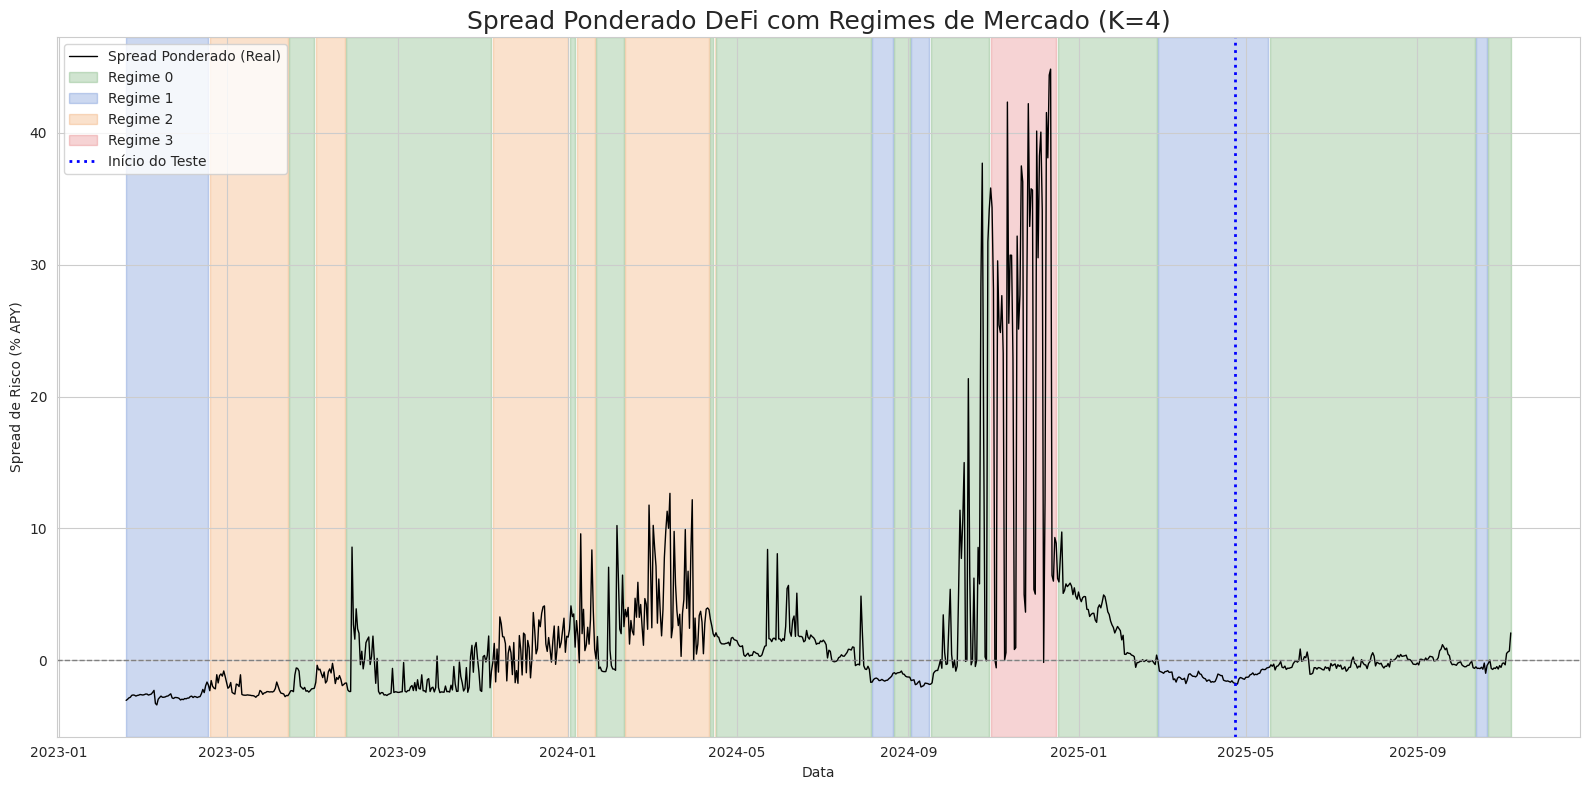

In [538]:
# Bloco 6: Visualização dos Regimes de Mercado (axvspan plot)

# 1. Juntar treino e teste para plotagem contínua
df_plot = pd.concat([df_train, df_test])

# 2. Configurações de Plotagem
plt.figure(figsize=(16, 8))
# Usamos nosso NOVO alvo ponderado
target_plot_column = 'Y_Target_Spread_Ponderado'
# Cores para 4 clusters na ordem 0, 1, 2, 3
colors = ["#167c16", "#0040b6", "#e66b00", "#d62728"]  # Verde, Azul, Laranja, Vermelho
regime_names = [f'Regime {i}' for i in range(N_CLUSTERS)]

# 3. Plotar a linha do Spread
ax = sns.lineplot(data=df_plot, x=df_plot.index, y=target_plot_column, 
                  label='Spread Ponderado (Real)', color='black', linewidth=1.0)
ax.axhline(0, ls='--', color='grey', lw=1)

# 4. Loop para colorir o fundo (axvspan) - CORRIGIDO PARA ORDEM CORRETA
print("Plotando áreas dos regimes (axvspan)...")

# Primeiro, criar todas as áreas coloridas
for regime in range(N_CLUSTERS):
    regime_data = df_plot[df_plot['cluster'] == regime]
    if len(regime_data) > 0:
        # Encontrar blocos contínuos para este regime
        regime_indices = regime_data.index
        gaps = regime_indices[1:] != regime_indices[:-1] + pd.Timedelta(days=1)
        
        start_idx = 0
        for i in range(len(gaps)):
            if gaps[i]:
                # Plotar bloco até a lacuna
                ax.axvspan(regime_indices[start_idx], regime_indices[i], 
                          color=colors[regime], alpha=0.2, 
                          label=regime_names[regime] if start_idx == 0 else "", zorder=0)
                start_idx = i + 1
        
        # Plotar o último bloco
        ax.axvspan(regime_indices[start_idx], regime_indices[-1], 
                  color=colors[regime], alpha=0.2, 
                  label=regime_names[regime] if start_idx == 0 else "", zorder=0)

# 5. Linha de Divisão Treino/Teste
split_date = df_test.index[0]
ax.axvline(split_date, color='blue', linestyle=':', linewidth=2, label='Início do Teste')

# 6. Finalizar o Gráfico
ax.legend(loc='upper left')
plt.title(f'Spread Ponderado DeFi com Regimes de Mercado (K={N_CLUSTERS})', fontsize=18)
plt.ylabel('Spread de Risco (% APY)')
plt.xlabel('Data')
plt.tight_layout()
print("Gráfico de regimes salvo como 'spread_com_regimes_kmeans.png'")
plt.show()


--- Análise dos Centroides (Média das features Z-score por cluster) ---
cluster                               0          1          2          3
X_Lag_1D                       0.948428  -1.822090   1.028482  31.921881
X_Lag_3D                       2.051588  -1.756028   1.454742  18.228384
X_Lag_7D                       1.763305  -1.593462   1.096549  22.428563
X_Aave_Utilization_Lag1        0.859235   0.679707   0.875446   0.978589
X_USDC_Depeg_Risk_Lag1         0.295866   0.325242   0.370657   0.359465
X_VIX_Lag1                    15.544113  22.938639  14.622773  16.232051
X_DGS2_Lag1                    4.545733   4.061088   4.532000   4.208205
X_Gas_Price_Gwei_Lag1         15.159088  15.509504  44.551293  21.113358
X_ETH_Returns_Lag1            -0.001403  -0.002859   0.004563   0.011275
X_ETH_Vol_7D_Lag1              0.064760   0.104083   0.073326   0.098303
X_BTC_Returns_Lag1             0.000525   0.001082   0.004173   0.009435
X_BTC_Vol_7D_Lag1              0.053665   0.081834 

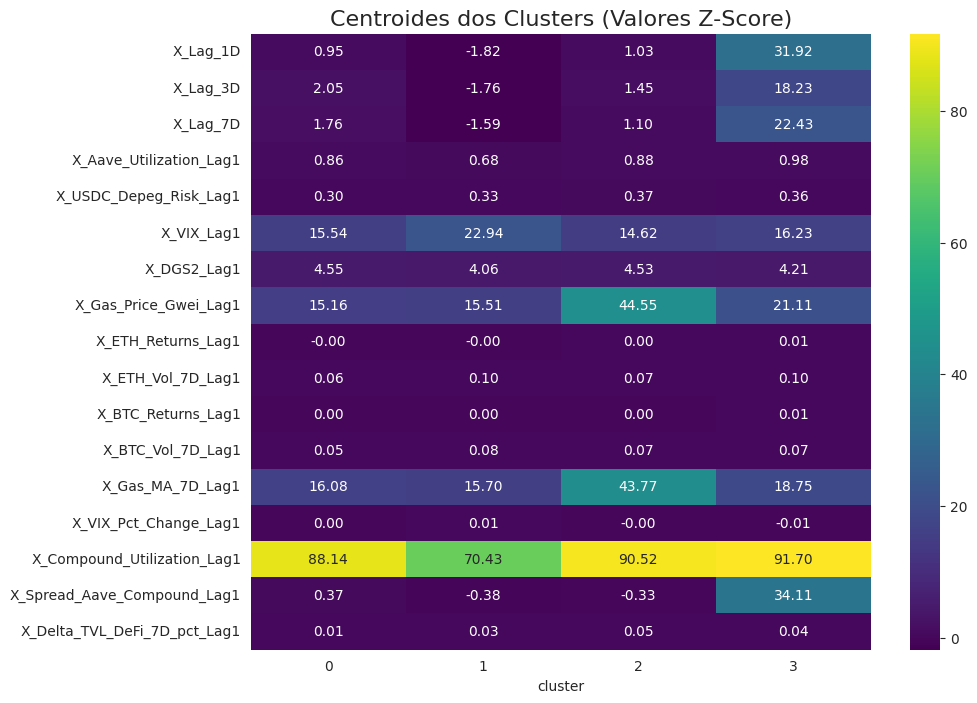

In [539]:
# Bloco 5: Análise dos Centroides (O que cada cluster significa?)

# Criar um dataframe de análise com os dados de treino padronizados
# MUDANÇA AQUI: Usar um novo nome de variável para não poluir o X_regress_train
X_train_analysis_centroids = X_regress_train.copy()
X_train_analysis_centroids['cluster'] = train_regimes

# Agrupar por cluster e calcular a média (centroides)
# Usamos os dados padronizados (X_train_scaled) para a análise,
# pois as médias dos dados brutos teriam escalas diferentes.
# MUDANÇA AQUI: Usar o novo nome de variável
cluster_centers = X_train_analysis_centroids.groupby('cluster').mean().T

print("\n--- Análise dos Centroides (Média das features Z-score por cluster) ---")
print(cluster_centers)

# Plotar um heatmap para visualizar facilmente
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_centers, annot=True, cmap='viridis', fmt='.2f')
plt.title('Centroides dos Clusters (Valores Z-Score)', fontsize=16)
plt.plot()
print("\nHeatmap dos centroides salvo como 'cluster_centroids_heatmap.png'")

In [540]:
df_train.head()

,Y_Aave_APY,X_Aave_Utilization,totalValueLockedUSD,Y_SOFR,X_USDC_Depeg_Risk,X_BTC_Price,X_ETH_Price,X_VIX,X_DGS2,X_Gas_Price_Gwei,...,X_ETH_Vol_7D_Lag1,X_BTC_Returns_Lag1,X_BTC_Vol_7D_Lag1,X_Gas_MA_7D_Lag1,X_VIX_Pct_Change_Lag1,X_Compound_Utilization_Lag1,X_Spread_Aave_Compound_Lag1,X_Delta_TVL_DeFi_7D_pct_Lag1,cluster,cluster_original_sem_filtro
date,,,,,,,,,,,,,,,,,,,,,
2023-02-18,1.547731,0.622046,4.371902e+07,4.55,0.365202,24626.23,1691.22,20.02,4.60,30.627716,...,0.092090,0.046609,0.111953,37.595934,-0.007437,68.244036,-0.293166,0.178870,1,1
2023-02-19,1.871218,0.683973,4.475597e+07,4.55,0.368955,24316.05,1680.92,20.02,4.60,29.673224,...,0.093900,0.002613,0.112934,38.911982,0.000000,46.033044,0.051635,0.668343,1,1
2023-02-20,2.048470,0.715639,4.519106e+07,4.55,0.363839,24835.63,1703.34,21.23,4.60,37.171212,...,0.090852,-0.012596,0.115319,40.141351,0.000000,47.078418,0.335157,0.655391,1,1
2023-02-21,2.245316,0.749240,4.388486e+07,4.55,0.355625,24447.91,1659.19,22.87,4.67,37.349600,...,0.087798,0.021368,0.113715,41.223577,0.060440,50.153984,0.418477,0.608770,1,1
2023-02-22,2.050248,0.715958,4.635428e+07,4.55,0.364668,24187.63,1643.17,22.29,4.66,40.866933,...,0.095439,-0.015611,0.119101,37.408367,0.077249,50.784943,0.594832,0.576711,1,1


# testando

In [ ]:
# --- Imports Necessários ---
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
# (Assumindo que as outras variáveis como N_CLUSTERS, X_regress_train, etc., já estão definidas)

# --- 6. Modelagem (COM HYPERPARAMETER TUNING E SELEÇÃO DO MELHOR) ---

# --- Definir Grids de Parâmetros ---
param_grid_xgb = {
    'n_estimators': [100, 200], 'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1], 'subsample': [0.8, 1.0]
}
param_grid_rf = {
    'n_estimators': [100, 200], 'max_depth': [2, 3, 5, 10, None],
    'min_samples_leaf': [1, 2, 5], 'max_features': ['sqrt', 0.8]
}
param_grid_svr = {
    'model__kernel': ['rbf', 'linear'], 'model__C': [1, 10, 100],
    'model__gamma': ['scale', 'auto']
}

# Dicionários para guardar os modelos puros (para comparação)
models_by_cluster_xgb = {}
models_by_cluster_rf = {}
models_by_cluster_svr = {}

# --- NOVO: Dicionários para o Modelo Híbrido ---
# best_models_hybrid: Guarda o *objeto* do modelo vencedor
# best_model_types: Guarda o *nome* do modelo vencedor (para log)
best_models_hybrid = {}
best_model_types = {}

print("\n" + "="*50)
print("--- Treinando Modelos (XGB, RF, SVR) com GridSearchCV por Cluster ---")
print("--- E selecionando o MELHOR para o modelo Híbrido ---")

# --- Validação Cruzada para Séries Temporais ---
tscv = TimeSeriesSplit(n_splits=3)

for cluster_id in range(N_CLUSTERS):
    X_train_cluster = X_regress_train[df_train['cluster'] == cluster_id]
    y_train_cluster = y_train[df_train['cluster'] == cluster_id]
    
    if len(X_train_cluster) < 20: 
        print(f"\nCluster {cluster_id}: Pulando (poucos dados de treino).")
        models_by_cluster_xgb[cluster_id] = None
        models_by_cluster_rf[cluster_id] = None
        models_by_cluster_svr[cluster_id] = None
        best_models_hybrid[cluster_id] = None 
        continue

    # Dicionário para guardar os melhores scores (RMSE) e modelos deste cluster
    cluster_best_scores = {}
    cluster_best_estimators = {}

    # --- Modelo 1: XGBoost ---
    print(f"\nCluster {cluster_id}: Iniciando GridSearchCV (XGBoost)...")
    xgb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
    grid_search_xgb = GridSearchCV(
        estimator=xgb, param_grid=param_grid_xgb, cv=tscv,
        n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=0
    )
    grid_search_xgb.fit(X_train_cluster, y_train_cluster)
    
    models_by_cluster_xgb[cluster_id] = grid_search_xgb.best_estimator_
    cluster_best_scores['xgb'] = grid_search_xgb.best_score_ # É neg_rmse, então MAIOR é MELHOR
    cluster_best_estimators['xgb'] = grid_search_xgb.best_estimator_
    print(f"Cluster {cluster_id} (XGB): Melhor RMSE (CV): {grid_search_xgb.best_score_:.4f}")

    # --- Modelo 2: RandomForest ---
    print(f"Cluster {cluster_id}: Iniciando GridSearchCV (RandomForest)...")
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search_rf = GridSearchCV(
        estimator=rf, param_grid=param_grid_rf, cv=tscv,
        n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=0
    ) 
    grid_search_rf.fit(X_train_cluster, y_train_cluster) 
    
    models_by_cluster_rf[cluster_id] = grid_search_rf.best_estimator_ 
    cluster_best_scores['rf'] = grid_search_rf.best_score_
    cluster_best_estimators['rf'] = grid_search_rf.best_estimator_
    print(f"Cluster {cluster_id} (RF): Melhor RMSE (CV): {grid_search_rf.best_score_:.4f}")

    # --- Modelo 3: SVR com Pipeline ---
    print(f"Cluster {cluster_id}: Iniciando GridSearchCV (SVR)...")
    pipe_svr = Pipeline([('scaler', StandardScaler()), ('model', SVR())])
    grid_search_svr = GridSearchCV(
        estimator=pipe_svr, param_grid=param_grid_svr, cv=tscv,
        n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=0
    )
    grid_search_svr.fit(X_train_cluster, y_train_cluster)
    
    models_by_cluster_svr[cluster_id] = grid_search_svr.best_estimator_
    cluster_best_scores['svr'] = grid_search_svr.best_score_
    cluster_best_estimators['svr'] = grid_search_svr.best_estimator_
    print(f"Cluster {cluster_id} (SVR): Melhor RMSE (CV): {grid_search_svr.best_score_:.4f}")

    # --- NOVO: Decidir o melhor modelo para o Híbrido ---
    # Estamos usando 'neg_root_mean_squared_error', então o MAIOR score é o melhor
    # (pois -50 é maior/melhor que -100)
    best_type = max(cluster_best_scores, key=cluster_best_scores.get)
    best_estimator = cluster_best_estimators[best_type]
    best_score = cluster_best_scores[best_type]

    best_models_hybrid[cluster_id] = best_estimator
    best_model_types[cluster_id] = best_type
    
    print(f"\n--- Cluster {cluster_id}: MELHOR MODELO HÍBRIDO SELECIONADO ---")
    print(f"--- Tipo: {best_type.upper()} (RMSE CV: {best_score:.4f}) ---")

print("\n--- Treinamento Concluído ---")
print("\nResumo do Modelo Híbrido (Melhor por Cluster):")
print(best_model_types)


--- Treinando Modelos (XGB, RF, SVR) com GridSearchCV por Cluster ---
--- E selecionando o MELHOR para o modelo Híbrido ---

Cluster 0: Iniciando GridSearchCV (XGBoost)...
Cluster 0 (XGB): Melhor RMSE (CV): -3.8550
Cluster 0: Iniciando GridSearchCV (RandomForest)...
Cluster 0 (RF): Melhor RMSE (CV): -3.7242
Cluster 0: Iniciando GridSearchCV (SVR)...
Cluster 0 (SVR): Melhor RMSE (CV): -3.1558

--- Cluster 0: MELHOR MODELO HÍBRIDO SELECIONADO ---
--- Tipo: SVR (RMSE CV: -3.1558) ---

Cluster 1: Iniciando GridSearchCV (XGBoost)...
Cluster 1 (XGB): Melhor RMSE (CV): -0.5283
Cluster 1: Iniciando GridSearchCV (RandomForest)...
Cluster 1 (RF): Melhor RMSE (CV): -0.5092
Cluster 1: Iniciando GridSearchCV (SVR)...
Cluster 1 (SVR): Melhor RMSE (CV): -0.3329

--- Cluster 1: MELHOR MODELO HÍBRIDO SELECIONADO ---
--- Tipo: SVR (RMSE CV: -0.3329) ---

Cluster 2: Iniciando GridSearchCV (XGBoost)...
Cluster 2 (XGB): Melhor RMSE (CV): -2.8991
Cluster 2: Iniciando GridSearchCV (RandomForest)...
Cluster 

In [542]:

# --- 7. GERAÇÃO DE PREDIÇÕES (Abordagem Híbrida - O MELHOR POR CLUSTER) ---
print("\nGerando predições no conjunto de teste (Híbrido - Melhor por Cluster)...")

predictions_hybrid_final = pd.Series(index=X_regress_test.index, dtype=float, name="predicted_hybrid")

# Iterar sobre o dicionário de melhores modelos que criamos no treino
for cluster_id, model in best_models_hybrid.items():
    
    # Checar se o modelo existe (pode ser None se o cluster foi pulado)
    if model is None: 
        print(f"Cluster {cluster_id}: Pulando (modelo nulo).")
        continue
        
    # Checar se há dados de teste para este cluster
    if cluster_id not in df_test['cluster'].values:
        print(f"Cluster {cluster_id}: Pulando (sem dados no teste).")
        continue
    
    # Encontrar os dados de teste para este cluster
    X_test_cluster = X_regress_test[df_test['cluster'] == cluster_id]
    
    if not X_test_cluster.empty:
        # Usar o melhor modelo (seja ele XGB, RF ou SVR) para prever
        preds_cluster = model.predict(X_test_cluster)
        predictions_hybrid_final.loc[X_test_cluster.index] = preds_cluster
        
        # Logar qual modelo foi usado (do dicionário que salvamos no Bloco 1)
        model_type = best_model_types.get(cluster_id, "N/D") 
        print(f"Cluster {cluster_id}: Aplicando predição do MELHOR modelo ({model_type.upper()}).")


# --- 8. ANÁLISE DETALHADA (Modelo Híbrido) ---
print("\n" + "="*50)
print("--- Performance de TESTE Detalhada (Modelo Híbrido - Melhor por Cluster) ---")

# Criar o DataFrame de resultados com as predições híbridas
results_hybrid = pd.DataFrame({'actual': y_test, 'predicted': predictions_hybrid_final})
results_hybrid = results_hybrid.join(df_test['cluster']).dropna()

# (O resto do código de análise e plotagem é IDÊNTICO ao anterior)
# (Ele já está configurado para usar 'results_hybrid' e 'predictions_hybrid_final')

cluster_performance = []
r2_scores = {} # Dicionário para guardar R² para o gráfico

if results_hybrid.empty:
    print("Nenhuma predição válida gerada para o Modelo Híbrido.")
    r2_scores['hybrid'] = np.nan
else:
    for cluster_id in range(N_CLUSTERS):
        cluster_df = results_hybrid[results_hybrid['cluster'] == cluster_id]
        count = len(cluster_df)
        if count < 2: mae, r2, rmse = np.nan, np.nan, np.nan
        else:
            mae = mean_absolute_error(cluster_df['actual'], cluster_df['predicted'])
            r2 = r2_score(cluster_df['actual'], cluster_df['predicted'])
            mse = mean_squared_error(cluster_df['actual'], cluster_df['predicted'])
            rmse = np.sqrt(mse) 
        cluster_performance.append({'Cluster': cluster_id, 'Pontos_no_Teste': count, 'MAE': mae, 'R2': r2, 'RMSE': rmse})

    performance_df = pd.DataFrame(cluster_performance).set_index('Cluster')
    print("--- Tabela Resumo da Performance (Conjunto de Teste - Híbrido) ---")
    print(performance_df.to_markdown(floatfmt=".4f"))
    print("="*50)

    mae_global = mean_absolute_error(results_hybrid['actual'], results_hybrid['predicted'])
    r2_global = r2_score(results_hybrid['actual'], results_hybrid['predicted'])
    mse_global = mean_squared_error(results_hybrid['actual'], results_hybrid['predicted'])
    rmse_global = np.sqrt(mse_global)
    print(f"\nMAE Global (Híbrido): {mae_global:.4f}")
    print(f"R² Global (Híbrido):  {r2_global:.4f}")
    print(f"RMSE Global (Híbrido): {rmse_global:.4f}")
    r2_scores['hybrid'] = r2_global


Gerando predições no conjunto de teste (Híbrido - Melhor por Cluster)...
Cluster 0: Aplicando predição do MELHOR modelo (SVR).
Cluster 1: Aplicando predição do MELHOR modelo (SVR).
Cluster 2: Pulando (sem dados no teste).
Cluster 3: Pulando (sem dados no teste).

--- Performance de TESTE Detalhada (Modelo Híbrido - Melhor por Cluster) ---
--- Tabela Resumo da Performance (Conjunto de Teste - Híbrido) ---
|   Cluster |   Pontos_no_Teste |      MAE |       R2 |     RMSE |
|----------:|------------------:|---------:|---------:|---------:|
|         0 |          165.0000 |   0.2514 |   0.4339 |   0.3429 |
|         1 |           34.0000 |   0.2286 |   0.5324 |   0.2757 |
|         2 |            0.0000 | nan      | nan      | nan      |
|         3 |            0.0000 | nan      | nan      | nan      |

MAE Global (Híbrido): 0.2475
R² Global (Híbrido):  0.6217
RMSE Global (Híbrido): 0.3324
